In [1]:
import pandas as pd
import numpy as np
import datetime
import netCDF4
from glob import glob
import scipy
from scipy.interpolate import griddata
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import os

### **Process & Interpolate Feature Datasets Pipeline**

In [65]:
print('--0--Downloading feature datasets for 2019 & 2020\n')
# ! sh get_feature_data_2019.sh
! sh get_feature_data_2020.sh
! python3 process_pred_dataset.py

--0--Downloading feature datasets for 2019 & 2020

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44.6M  100 44.6M    0     0   881k      0  0:00:51  0:00:51 --:--:-- 1049k:01:06  868k0:00:48 1161k00:22  0:00:40  673k  0:00:16 1117k
/Users/oliverwaring/repos/subseasonal-rodeo/submissions/submission_period21/code/scripts
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2405k  100 2405k    0     0   421k      0  0:00:05  0:00:05 --:--:--  487k
/Users/oliverwaring/repos/subseasonal-rodeo/submissions/submission_period21/code/scripts
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9005k  100 9005k    0     0   725k      0  0:00:12  0:00:12 --:--:--  890k


### **Load Processed Feature Datasets**

In [70]:
df = np.load('../data/mv_model_pred_inputs/processed_features.npy')

In [71]:
df = pd.DataFrame(df)
col_names = pd.read_csv('../data/standardization/column_names.csv')
full_col_names = list(col_names['0'])
col_names = list(col_names['0'])
col_names.remove('tmp2m'), col_names.remove('precip')
df.columns = col_names
df.head(-10)

,start_date,lat,lon,pres,contest_wind_hgt_10,rhum,slp,pr_wtr,pevpr,month_sin,month_cos,dayofyear_sin,dayofyear_cos
0,2019-01-01,27,261,97283.5,30398.2,88.325,101804,8.13786,10.9524,0.5,0.866025,0.0171663,0.999853
1,2019-01-02,27,261,97214.5,30346.6,88.4179,101688,8.55643,12.2513,0.5,0.866025,0.0343276,0.999411
2,2019-01-03,27,261,97362.2,30288.2,88.8036,101833,8.37464,11.0438,0.5,0.866025,0.0514788,0.998674
3,2019-01-04,27,261,97505.3,30231.7,89.2786,102001,7.78071,9.95837,0.5,0.866025,0.0686147,0.997643
4,2019-01-05,27,261,97684.6,30178.8,90.2107,102196,7.03214,9.53193,0.5,0.866025,0.0857305,0.996318
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290395,2020-07-04,49,262,99870.5,31306.3,68.1821,101305,35.0536,541.928,-0.5,-0.866025,-0.0514788,-0.998674
290396,2020-07-05,49,262,99886,31303.1,68.825,101317,36.0843,535.639,-0.5,-0.866025,-0.0686147,-0.997643
290397,2020-07-06,49,262,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.866025,-0.0857305,-0.996318
290398,2020-07-07,49,262,NaN,NaN,NaN,NaN,NaN,NaN,-0.5,-0.866025,-0.102821,-0.9947


### **Download Temperature & Pressure Datasets**

In [ ]:
# ! sh get_tar_data.sh

In [72]:
def load_tar_datasets(pred_var):
    """ Assumes all datasets are downloaded """
    path = '../data/' # use your path
    all_files = glob(path + "gt*.csv")
    all_files.sort()

    for i, filename in enumerate(all_files):
        if i == 0:
            df = pd.read_csv(filename, index_col=None, header=0)
            df['region_id'] = list(zip(df['lat'],df['lon']))
            df = df[['lat','lon','region_id',pred_var]].copy()
            df.columns = ['lat','lon','region_id'] + [str(col)+'_'+str(filename[6:-4]) for col in df.columns[3:]]
            file_list = [df]
        else:
            df = pd.read_csv(filename, index_col=None, header=0)
            df = df[[pred_var]].copy()
            df.columns = [str(col)+'_'+str(filename[6:-4]) for col in df.columns]
            file_list.append(df)

    frame = pd.concat(file_list, axis=1, ignore_index=False)
    return(frame)

def process_tar_datasets(pred_var, weeks, col):
    assert col in ['tmp','prec']
    assert pred_var in ['temp34','prec34']
    tmp = load_tar_datasets(pred_var)
    tmp_list = []
    for rgn in tmp['region_id'].unique():
        region_tmp = pd.DataFrame(tmp[tmp['region_id']==rgn].iloc[0,-weeks:].values, columns=[col])
        region_tmp['lat'] = rgn[0]
        region_tmp['lon'] = rgn[1]
        tmp_list.append(region_tmp)
    tmp_df = pd.concat(tmp_list, axis=0, ignore_index=False)
    tmp_df = tmp_df.reset_index(drop=True)
    return tmp_df

### **Prepare Input Sequences**

<span style="color:orange">**INPUT PREDICTION PERIOD DATE AND LAST AVAILABLE START DATE**</span>

In [73]:
def get_prediction_dataset(pred_date, latest_data_date, data=df, seq_len=26):
    """ Get input data for current target week from features dataset.
        Note start date for these is two weeks behind current date.
        Note usually data is not available for latest day - in which case take latest
            available data date for last data point in input sequence.
        Get temp/prec data using get_gt.py method, and join to features datasets.
        Note - for a given date, these interpolate and 2 week average the values 3/4 weeks ahead of date.
        Therefore we process differently - these start dates are 28 days behind current prediction date. """
    # Features data
    prediction_date = datetime.datetime.strptime(pred_date,'%Y-%m-%d')
    last_start_date = prediction_date - datetime.timedelta(days=14)
    last_available_start_date = datetime.datetime.strptime(latest_data_date,'%Y-%m-%d')
    pred_date_index = [last_available_start_date] + [last_start_date - datetime.timedelta(days=x) for x in range(14,14*seq_len,14)]
    data = data[data.start_date.isin(pred_date_index)].reset_index(drop=True)
    # Temp/prec data
    tmp = process_tar_datasets('temp34', seq_len, 'tmp')
    prec = process_tar_datasets('prec34', seq_len, 'prec')
    # Join all
    data['precip'] = prec['prec']
    data['tmp2m'] = tmp['tmp']
    data = data[full_col_names]
    return data

In [74]:
pred_input = get_prediction_dataset(pred_date='2020-07-21', latest_data_date='2020-07-05', data=df)

In [75]:
pred_input

,start_date,lat,lon,tmp2m,precip,pres,contest_wind_hgt_10,rhum,slp,pr_wtr,pevpr,month_sin,month_cos,dayofyear_sin,dayofyear_cos
0,2019-07-23,27,261,31.1734,2.26964,97205,31709.6,61.0321,101402,23.6068,477.734,-0.5,-0.866025,-0.352752,-0.935717
1,2019-08-06,27,261,33.4889,0.0274229,96945.7,31676.1,65.6357,101142,23.5543,349.034,-0.866025,-0.5,-0.565345,-0.824855
2,2019-08-20,27,261,32.189,28.4737,97140.9,31557.3,66.6464,101349,21.5514,399.404,-0.866025,-0.5,-0.745438,-0.666575
3,2019-09-03,27,261,29.4765,61.8688,97304.1,31315.9,81.4107,101517,23.795,202.593,-1,-1.83697e-16,-0.882679,-0.469977
4,2019-09-17,27,261,30.7186,1.64144,96660,31133,79.3179,100872,22.4282,198.62,-1,-1.83697e-16,-0.969178,-0.246361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13359,2020-05-12,49,262,13.85,17.7868,99506.8,31184.7,78.8929,100983,33.3546,284.606,0.5,-0.866025,0.756771,-0.65368
13360,2020-05-26,49,262,16.3793,30.5972,99804.2,31240.4,80.5,101272,38.48,231.875,0.5,-0.866025,0.579421,-0.815028
13361,2020-06-09,49,262,17.051,19.8579,100055,31287.4,68.125,101505,34.245,397.159,1.22465e-16,-1,0.368763,-0.929523
13362,2020-06-23,49,262,22.3872,48.5668,99767.1,31307.1,77.2179,101201,39.9118,370.94,1.22465e-16,-1,0.136906,-0.990584


### **Prepare Prediction Input for Models**

In [76]:
feature_means = np.array(np.load('../data/standardization/feature_means.npy'))
feature_stds = np.array(np.load('../data/standardization/feature_stds.npy'))
feature_scaler = joblib.load('../data/standardization/all_feature_scaler.pkl', "r" )
prec_scaler = joblib.load('../data/standardization/prec_scaler.pkl', "r" )
tmp_scaler = joblib.load('../data/standardization/temp_scaler.pkl', "r" )

locations = pd.read_csv('../target_points.csv')
locations['region_id'] = list(zip(locations['lat'], locations['lon']))

/usr/local/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [77]:
class PreprocessTemporalSpatialDataPrediction:
    """
    Class for conducting preprocessing pipeline for temporal spatial data
    Standardizes feature fields, and scales all categorical feature fiels
    Transforms dataset to spatial form [timesteps,lat,lon,features]
    Creates missing regions to enable above matrix transformation (filling in missing value with 0 - note this aligns well with [0,1] scaling)


    """
    def __init__(self, scaler, data_mean, data_std, data:np.array, locations:np.array, col_names:list, num_regions:int, num_features:int, max_sg:int=5):
        self.scaler = scaler
        self.data_mean = data_mean
        self.data_std = data_std
        self.data = data
        self.locations = locations
        self.regions = self.locations['region_id'].unique()
        self.latmin, self.latmax, self.lonmin, self.lonmax = self.locations['lat'].min(), self.locations['lat'].max(), self.locations['lon'].min(), self.locations['lon'].max()
        self.bin_width, self.bin_height = self.lonmax - self.lonmin + 1, self.latmax - self.latmin + 1
        self.col_names = col_names
        self.num_regions = num_regions
        self.num_features = num_features
        self.weather_features = 8
        self.cyclical_features = 4
        self.num_timesteps = self.data.reshape(self.num_regions, -1, self.num_features).shape[1]
        self.max_sg = max_sg
        
    def standardize_and_scale_data(self):
        """ Standarize features using mean, std from train set; then scale to 0-1 scale """
        # Ensure dataset is order by start date, by region (lat, then lon)
#         self.data = self.data.sort_values(by=['start_date', 'lat','lon']).reset_index(drop=True)
        # Reshape all regions together
        self.data  = np.array(self.data).reshape(-1, self.num_features)
        # Extract train_split - note we only standardize using mean and std from train set
        TRAIN_SPLIT = self.num_timesteps #- 2*1008*self.num_regions
        
        # Start Date - need this for indexing/grouping by region
        date = self.data[:,0].reshape((-1,1))

        # Keep lat/lon from scaling
        lat_lon = self.data[:,1:3].astype(np.float16)

        # Standardize feature fields using training means & stds
        features = self.data[:,3:-4].astype(np.float32)
        features = ((features-self.data_mean)/self.data_std).astype(np.float16)
        
        # Deal with cyclical features separately - these are already scaled
        cyclical_features = self.data[:,-4:].astype(np.float16)

        # All features - stack and scale
        all_features = np.hstack((features, cyclical_features))

        # Scale feature data to 0-1 scale using training scaler
        scaler = self.scaler
        all_features = scaler.fit_transform(all_features)
        
        # Recombine & Reshape
        self.data = np.hstack((date, lat_lon, all_features))
        self.data = self.data.reshape(-1, self.num_features)

        
    def process_datetime(self, dt_fmt:str='%Y-%m-%d', datetimecol='start_date'):
        #print("Parsing datetime fields \n")
        def lookup(s):
            """
            This is an extremely fast approach to datetime parsing.
            """
            dates = {date:pd.to_datetime(date, format = dt_fmt) for date in s.unique()}
            return s.map(dates)
        self.data[datetimecol] = lookup(self.data[datetimecol])
        self.all_dates = np.unique(self.data["start_date"].dt.strftime('%Y-%m-%d'))
        
    def get_missing_regions(self):
        """ Find regions in lat-lon box which are not modelled geographic regions  """
        self.all_region_ids = [(lat,lon) for lat in range(self.latmin, self.latmax+1) for lon in range(self.lonmin,self.lonmax+1)]
        self.num_total_regions = len(set(self.all_region_ids))
        self.missing_regions = list(set(self.all_region_ids) - set(list(self.regions)))
        self.missing_regions.sort() 
        
    def mask_missing_regions(self, mask_value=0):
        """ Create masked data for missing region - zero pad (0,1) scaled features """
        self.get_missing_regions()
        masked_rgn_lst = []
        for rgn in self.missing_regions:
            date_col = self.data.reshape(self.num_regions,-1,self.num_features)[0,:,0].reshape(self.num_timesteps,1) #take same dates
            lat_col = np.array([rgn[0]]*self.num_timesteps).reshape(self.num_timesteps,1) #take lat of current region
            lon_col = np.array([rgn[1]]*self.num_timesteps).reshape(self.num_timesteps,1) #take lon of current region
            feature_cols = np.array([mask_value]*self.num_timesteps*(self.weather_features)).reshape(self.num_timesteps,self.weather_features) #mask weather features
            cyclical_cols = self.data.reshape(self.num_regions,-1,self.num_features)[0,:,-self.cyclical_features:].reshape(self.num_timesteps,self.cyclical_features) #take time features
            masked_rgn = np.hstack((date_col, lat_col, lon_col, feature_cols, cyclical_cols))
            masked_rgn_lst.append(masked_rgn)
        masked_rgns = np.concatenate(masked_rgn_lst)
        self.masked_rgns_df = pd.DataFrame(masked_rgns)
        self.masked_rgns_df.columns = self.col_names
        self.masked_rgns_df['region_id'] = list(zip(self.masked_rgns_df['lat'].astype(int), self.masked_rgns_df['lon'].astype(int)))
        self.masked_rgns_df['model_region'] = False
        
    def convert_rgns_data_to_df(self):
        """ Convert to df of shape (num_timesteps*num_regions, num_features). Ordered by region by timestep """
        self.data = pd.DataFrame(self.data.reshape(-1,self.num_features))
        self.data.columns = self.col_names
        # Create unique region id
        self.data['region_id'] = list(zip(self.data['lat'].astype(int), self.data['lon'].astype(int)))
        self.data['model_region'] = True
        
    def join_masked_regions(self):
        """ Join masked regions df to rgns data df, and sort """
        self.data = pd.concat([self.data, self.masked_rgns_df])
        # Convert date to datetime
        self.process_datetime()
        # Sort
        self.data = self.data.sort_values(by=['lat', 'lon', 'start_date']).reset_index(drop=True)
        assert self.num_total_regions == len(self.data['region_id'].unique())
        
    def get_global_region_tensor(self, save=False):
        print("Generating global spatial grid \n")
        spatial_tw_list = []
#         self.all_dates = np.sort(self.data['start_date'].unique())
        # For every timestep, create binsize*binsize global spatial grid of demand
        for counter, time_window in enumerate(self.all_dates):
            mask = self.data['start_date'] == np.datetime64(time_window)
            pvt_current_time_window = np.flipud(np.array(self.data[mask]).reshape(self.bin_height,self.bin_width,-1))
            spatial_tw_list.append(pvt_current_time_window)
        # Store global_regions_tensor - stack as tensor: for bin_index [num_timesteps, bin_width , bin_height, number of channels]
        self.global_region_tensor = np.stack(spatial_tw_list).reshape(-1,self.bin_height,self.bin_width,pvt_current_time_window.shape[2])
        self.global_region_tensor = self.global_region_tensor[:,:,:,:-2]

        # Pad outer edge with max spatial granularity
        npad = ((0, 0), (self.max_sg, self.max_sg), (self.max_sg, self.max_sg), (0, 0)) # pad (before, after) on region height/width dimensions only
        self.global_region_tensor = np.pad(self.global_region_tensor, pad_width = npad, mode='constant', constant_values=0)
        # Save to disk
        if save:
            print("Saving global spatial tensor \n")
            np.save(repo_path+'/data/processed/spatial_temporal/global_region_tensor_scaled_sg'+str(self.max_sg), self.global_region_tensor)
            
    def get_target_regions(self):
        self.target_regions = self.locations['region_id'].unique()
        self.target_region_ids = [(self.locations['lat'].max()-region[0]+self.max_sg,region[1]-self.locations['lon'].min()+self.max_sg) for region in self.target_regions]
        
    def get_region_ids(self):
        self.get_target_regions()
        self.rgn_id_vocab = [str(region) for region in self.target_regions]
        self.rgn_id_to_int = {rgn_id:i for i, rgn_id in enumerate(self.rgn_id_vocab)}
        self.int_to_rgn_id = {i:rgn_id for i, rgn_id in enumerate(self.rgn_id_vocab)}
        return(self.rgn_id_vocab, self.rgn_id_to_int, self.int_to_rgn_id, self.target_region_ids)
    
    def preprocess_pipeline(self):
        self.standardize_and_scale_data()
        self.mask_missing_regions()
        self.convert_rgns_data_to_df()
        self.join_masked_regions()
        self.get_global_region_tensor()
        del self.data

In [78]:
y = PreprocessTemporalSpatialDataPrediction(feature_scaler, feature_means, feature_stds, np.array(pred_input),
                                            locations, full_col_names, num_regions=514, num_features=15, max_sg=5)
y.preprocess_pipeline()
input_dataset = y.global_region_tensor
rgn_id_vocab, rgn_id_to_int, int_to_rgn_id, target_region_ids = y.get_region_ids()

Generating global spatial grid 



In [79]:
def prepare_single_spatial_temporal_region(dataset, target_region, seq_len, sg, region_emb=True):
    """  """
    # Set future target prediction var based on model scenario
#     assert (tar_var in ['tmp','prec'])
    # Number of timesteps target is after training history
#     target_size = {'34':2,'56':4}[tar_week]*14 + 1
    # Column index of target variable
#     target_col = {'tmp':3,'prec':4}[tar_var]
    
    # Crop local region
    local_region = dataset[:,(target_region[0]-sg):(target_region[0]+sg+1),(target_region[1]-sg):(target_region[1]+sg+1),:]

    # Spatial data
    spatial_data = local_region[:,:,:,3:-4].astype(np.float16)
    # Temporal data
    if region_emb:
        local_reg_id = str((int(local_region[0,sg,sg,1]),int(local_region[0,sg,sg,2])))
        local_reg_id = rgn_id_to_int[local_reg_id]
        temporal_data = local_region[:,sg,sg,-4:].astype(np.float16)
        region_embedding = np.repeat(local_reg_id, seq_len).reshape(seq_len,1).astype(np.int16)
      # print(temporal_data.shape, region_embedding.shape)
    elif not region_emb:
        temporal_data = local_region[:,sg,sg,1:].astype(np.float16)
    # Target variable
#     target_data = np.array(local_region[0,sg,sg,target_col]).astype(np.float16)

    return np.array(spatial_data), np.array(temporal_data), np.array(region_embedding)#, np.array(target_data)

def generate_all_region_input():
    spatial_data, temporal_data, reg_emb_data = [], [], []
    for rgn in target_region_ids:
        # Generate single window
        spt, tmp, remb = prepare_single_spatial_temporal_region(input_dataset, rgn, seq_len=26, sg=5)
        spatial_data.append(spt)
        temporal_data.append(tmp)
        reg_emb_data.append(remb)
    spatial_data = np.stack(spatial_data)
    temporal_data = np.stack(temporal_data)
    reg_emb_data = np.stack(reg_emb_data)
    
    return(spatial_data, temporal_data, reg_emb_data)

**Predict in Batches**

*This is currently a complete hack, as model requires batch of 256 as input*

In [80]:
pred_model_input = generate_all_region_input()

spatial_input_b1 = pred_model_input[0][0:256,:,:,:,:]#.reshape(1,256,26,11,11,8)
temporal_input_b1 = pred_model_input[1][0:256,:,:]#.reshape(1,256,26,4)
reg_emb_input_b1 = pred_model_input[2][0:256,:,:]#.reshape(1,256,26,1)
spatial_input_b2 = pred_model_input[0][256:512,:,:,:,:]#.reshape(1,256,26,11,11,8)
temporal_input_b2 = pred_model_input[1][256:512,:,:]#.reshape(1,256,26,4)
reg_emb_input_b2 = pred_model_input[2][256:512,:,:]#.reshape(1,256,26,1)
spatial_input_b3 = pred_model_input[0][258:,:,:,:,:]#.reshape(1,256,26,11,11,8)
temporal_input_b3 = pred_model_input[1][258:,:,:]#.reshape(1,256,26,4)
reg_emb_input_b3 = pred_model_input[2][258::,:]#.reshape(1,256,26,1)

def batch_gen(spatial_data,temporal_data,reg_emb_data):
    yield({"spatial_input":spatial_data, "temporal_input":temporal_data, "region_id_input":reg_emb_data})

BATCH_SIZE,SEQ_LEN,SPATIAL_WIDTH,SPATIAL_FEATURES,TEMPORAL_FEATURES = 256,26,11,8,4
b1_generator = tf.data.Dataset.from_generator(
    generator=lambda: batch_gen(spatial_input_b1, temporal_input_b1, reg_emb_input_b1),
    output_types=({"spatial_input":np.float16,"temporal_input":np.float16,"region_id_input":np.int16}),
    output_shapes=({"spatial_input":[BATCH_SIZE,SEQ_LEN,SPATIAL_WIDTH,SPATIAL_WIDTH,SPATIAL_FEATURES], \
                    "temporal_input":[BATCH_SIZE,SEQ_LEN,TEMPORAL_FEATURES],
                    "region_id_input":[BATCH_SIZE,SEQ_LEN,1]}))
b2_generator = tf.data.Dataset.from_generator(
    generator=lambda: batch_gen(spatial_input_b2, temporal_input_b2, reg_emb_input_b2),
    output_types=({"spatial_input":np.float16,"temporal_input":np.float16,"region_id_input":np.int16}),
    output_shapes=({"spatial_input":[BATCH_SIZE,SEQ_LEN,SPATIAL_WIDTH,SPATIAL_WIDTH,SPATIAL_FEATURES], \
                    "temporal_input":[BATCH_SIZE,SEQ_LEN,TEMPORAL_FEATURES],
                    "region_id_input":[BATCH_SIZE,SEQ_LEN,1]}))
b3_generator = tf.data.Dataset.from_generator(
    generator=lambda: batch_gen(spatial_input_b3, temporal_input_b3, reg_emb_input_b3),
    output_types=({"spatial_input":np.float16,"temporal_input":np.float16,"region_id_input":np.int16}),
    output_shapes=({"spatial_input":[BATCH_SIZE,SEQ_LEN,SPATIAL_WIDTH,SPATIAL_WIDTH,SPATIAL_FEATURES], \
                    "temporal_input":[BATCH_SIZE,SEQ_LEN,TEMPORAL_FEATURES],
                    "region_id_input":[BATCH_SIZE,SEQ_LEN,1]}))

#### **Temp34 Model Prediction**

In [81]:
tmp34_model = tf.keras.models.load_model('../models/period21_tmp34_model.hdf5', compile=False)

In [82]:
# tmp34_model_input_b1 = tf.data.Dataset.from_tensor_slices(pred_model_input_b1)
tmp34_model_pred_b1 = tmp34_model.predict(b1_generator)
tmp34_model_pred_b2 = tmp34_model.predict(b2_generator)
tmp34_model_pred_b3 = tmp34_model.predict(b3_generator)
tmp34_model_pred = np.concatenate([tmp34_model_pred_b1, tmp34_model_pred_b2, tmp34_model_pred_b3[-2:]])

In [83]:
tmp_mean, tmp_std = feature_means[0], feature_stds[0]
tmp34_model_prediction = tmp_scaler.inverse_transform(tmp34_model_pred)
tmp34_model_prediction = tmp34_model_prediction*tmp_std + tmp_mean

In [84]:
tmp34_model_prediction

array([[30.616003 ],
       [29.593506 ],
       [30.238201 ],
       [28.907415 ],
       [28.648558 ],
       [29.499968 ],
       [29.228167 ],
       [28.845856 ],
       [28.32232  ],
       [27.747286 ],
       [23.818697 ],
       [24.289228 ],
       [26.901697 ],
       [27.251759 ],
       [26.869768 ],
       [26.756313 ],
       [27.596704 ],
       [28.229671 ],
       [27.911573 ],
       [27.801357 ],
       [27.215294 ],
       [24.65311  ],
       [22.935598 ],
       [25.349916 ],
       [25.89582  ],
       [25.51381  ],
       [25.208538 ],
       [26.034582 ],
       [26.891521 ],
       [28.029554 ],
       [27.730028 ],
       [27.407085 ],
       [27.214142 ],
       [32.213108 ],
       [30.29215  ],
       [27.855736 ],
       [26.38168  ],
       [24.966488 ],
       [25.010248 ],
       [25.87104  ],
       [25.414082 ],
       [23.953146 ],
       [25.086718 ],
       [25.801598 ],
       [25.488966 ],
       [25.701519 ],
       [26.00945  ],
       [26.01

#### **Temp56 Model Prediction**

In [85]:
tmp56_model = tf.keras.models.load_model('../models/period21_tmp56_model.hdf5', compile=False)

In [86]:
# tmp34_model_input_b1 = tf.data.Dataset.from_tensor_slices(pred_model_input_b1)
tmp56_model_pred_b1 = tmp56_model.predict(b1_generator)
tmp56_model_pred_b2 = tmp56_model.predict(b2_generator)
tmp56_model_pred_b3 = tmp56_model.predict(b3_generator)
tmp56_model_pred = np.concatenate([tmp56_model_pred_b1, tmp56_model_pred_b2, tmp56_model_pred_b3[-2:]])

In [87]:
tmp_mean, tmp_std = feature_means[0], feature_stds[0]
tmp56_model_prediction = tmp_scaler.inverse_transform(tmp56_model_pred)
tmp56_model_prediction = tmp56_model_prediction*tmp_std + tmp_mean

In [88]:
tmp56_model_prediction

array([[30.2524   ],
       [29.802494 ],
       [29.898603 ],
       [29.656727 ],
       [29.21508  ],
       [30.588852 ],
       [30.091541 ],
       [29.443146 ],
       [29.351269 ],
       [29.247492 ],
       [23.88666  ],
       [25.549126 ],
       [28.202517 ],
       [28.020643 ],
       [27.75974  ],
       [27.556358 ],
       [28.478947 ],
       [29.462614 ],
       [29.150917 ],
       [29.260124 ],
       [28.300947 ],
       [24.516243 ],
       [23.710024 ],
       [26.204967 ],
       [26.55431  ],
       [26.802786 ],
       [27.215502 ],
       [27.621288 ],
       [28.19351  ],
       [29.44915  ],
       [28.887207 ],
       [28.386215 ],
       [28.336    ],
       [32.923893 ],
       [30.356876 ],
       [27.40354  ],
       [25.745808 ],
       [24.778189 ],
       [25.060566 ],
       [25.94853  ],
       [25.815474 ],
       [24.90488  ],
       [26.543528 ],
       [26.69747  ],
       [26.571884 ],
       [26.61978  ],
       [26.635544 ],
       [27.01

#### **Prec34 Model Prediction**

In [89]:
prec34_model = tf.keras.models.load_model('../models/period21_prec34_model.hdf5', compile=False)

In [90]:
# tmp34_model_input_b1 = tf.data.Dataset.from_tensor_slices(pred_model_input_b1)
prec34_model_pred_b1 = prec34_model.predict(b1_generator)
prec34_model_pred_b2 = prec34_model.predict(b2_generator)
prec34_model_pred_b3 = prec34_model.predict(b3_generator)
prec34_model_pred = np.concatenate([prec34_model_pred_b1, prec34_model_pred_b2, prec34_model_pred_b3[-2:]])

In [91]:
prec_mean, prec_std = feature_means[1], feature_stds[1]
prec34_model_prediction = prec_scaler.inverse_transform(prec34_model_pred)
prec34_model_prediction = prec34_model_prediction*prec_std + prec_mean

In [92]:
prec34_model_prediction = np.array([0 if val < 0 else val for val in list(prec34_model_prediction.reshape(514))]).reshape(514,1)
prec34_model_prediction

array([[25.966305  ],
       [24.233238  ],
       [22.47349   ],
       [19.53321   ],
       [23.78595   ],
       [24.057377  ],
       [21.98546   ],
       [21.73132   ],
       [23.650944  ],
       [29.672424  ],
       [16.587238  ],
       [20.419426  ],
       [20.366415  ],
       [27.894394  ],
       [28.667505  ],
       [28.514637  ],
       [24.14324   ],
       [23.61403   ],
       [25.916702  ],
       [39.71434   ],
       [41.515022  ],
       [16.359165  ],
       [21.027447  ],
       [19.846249  ],
       [21.493217  ],
       [25.973812  ],
       [27.067436  ],
       [31.015121  ],
       [30.542568  ],
       [22.766909  ],
       [28.345873  ],
       [36.9952    ],
       [38.930016  ],
       [ 5.0786915 ],
       [ 8.101768  ],
       [13.892851  ],
       [19.595232  ],
       [26.227364  ],
       [22.146664  ],
       [16.419886  ],
       [16.731125  ],
       [19.741526  ],
       [15.441003  ],
       [16.112583  ],
       [20.75059   ],
       [24

#### **Prec56 Model Prediction**

In [93]:
prec56_model = tf.keras.models.load_model('../models/period21_prec56_model.hdf5', compile=False)

In [94]:
# tmp34_model_input_b1 = tf.data.Dataset.from_tensor_slices(pred_model_input_b1)
prec56_model_pred_b1 = prec56_model.predict(b1_generator)
prec56_model_pred_b2 = prec56_model.predict(b2_generator)
prec56_model_pred_b3 = prec56_model.predict(b3_generator)
prec56_model_pred = np.concatenate([prec56_model_pred_b1, prec56_model_pred_b2, prec56_model_pred_b3[-2:]])

In [95]:
prec_mean, prec_std = feature_means[1], feature_stds[1]
prec56_model_prediction = prec_scaler.inverse_transform(prec56_model_pred)
prec56_model_prediction = prec56_model_prediction*prec_std + prec_mean

In [96]:
prec56_model_prediction = np.array([0 if val < 0 else val for val in list(prec56_model_prediction.reshape(514))]).reshape(514,1).astype(float)
prec56_model_prediction

array([[22.87363243],
       [22.89696121],
       [20.02806854],
       [17.85048294],
       [21.58965683],
       [17.76610184],
       [18.13976097],
       [14.65164566],
       [19.46943283],
       [25.505867  ],
       [11.4990797 ],
       [10.49450588],
       [12.6914959 ],
       [15.77260017],
       [18.3843174 ],
       [19.18534279],
       [14.91257477],
       [11.9381752 ],
       [17.73108673],
       [30.35105515],
       [48.87450409],
       [16.34241104],
       [13.9259882 ],
       [11.23750687],
       [13.13113403],
       [16.70085907],
       [18.63996315],
       [15.88639641],
       [12.87325287],
       [10.75797749],
       [12.67130089],
       [20.13044739],
       [41.82050705],
       [ 6.75227547],
       [14.94200706],
       [17.74414062],
       [21.26449203],
       [17.7941246 ],
       [13.68574524],
       [11.79743195],
       [14.54967117],
       [16.86526299],
       [12.90012264],
       [12.92242527],
       [17.52965164],
       [19

## **Submission File**

In [97]:
submission_df = pd.read_csv('../target_points.csv')

In [98]:
submission_df['temp34'] = tmp34_model_prediction
submission_df['prec34'] = prec34_model_prediction
submission_df['temp56'] = tmp56_model_prediction
submission_df['prec56'] = prec56_model_prediction

In [99]:
submission_df.to_csv('../../2020-07-21.csv', index=False)

#### **Sense Check Plot**

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

In [101]:
submission_df['lat_adj'] = submission_df['lat'].max() - submission_df['lat']
submission_df['lon_adj'] = submission_df['lon'] - submission_df['lon'].min()
submission_df['region_id_adj'] = list(zip(submission_df['lat_adj'], submission_df['lon_adj']))

**tmp34**

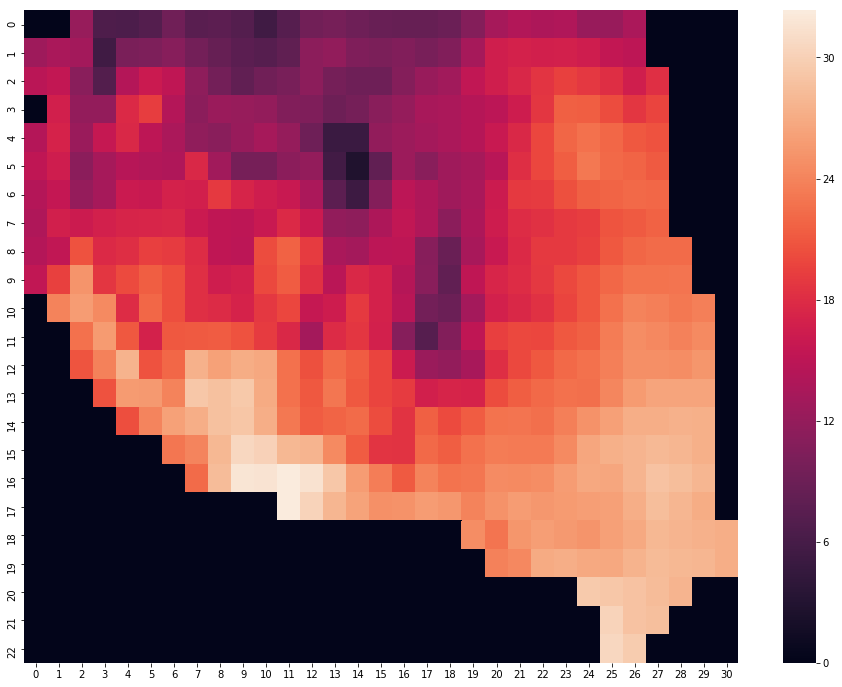

In [102]:
grid = np.zeros(shape = (submission_df['lat_adj'].max()+1, submission_df['lon_adj'].max()+1))
for region in submission_df['region_id_adj'].unique():
    i, j = region
    grid[i,j] = submission_df[(submission_df['lat_adj'] == i) & (submission_df['lon_adj'] == j)]['temp34']

plt.subplots(figsize=(16,12))
sns.heatmap(grid)

**tmp56**

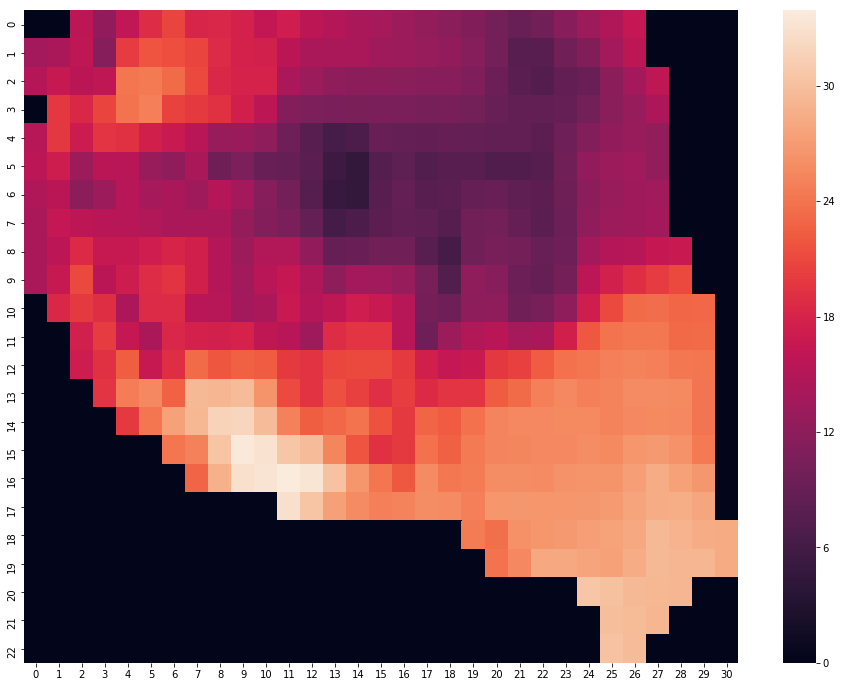

In [103]:
grid = np.zeros(shape = (submission_df['lat_adj'].max()+1, submission_df['lon_adj'].max()+1))
for region in submission_df['region_id_adj'].unique():
    i, j = region
    grid[i,j] = submission_df[(submission_df['lat_adj'] == i) & (submission_df['lon_adj'] == j)]['temp56']

plt.subplots(figsize=(16,12))
sns.heatmap(grid)

**prec34**

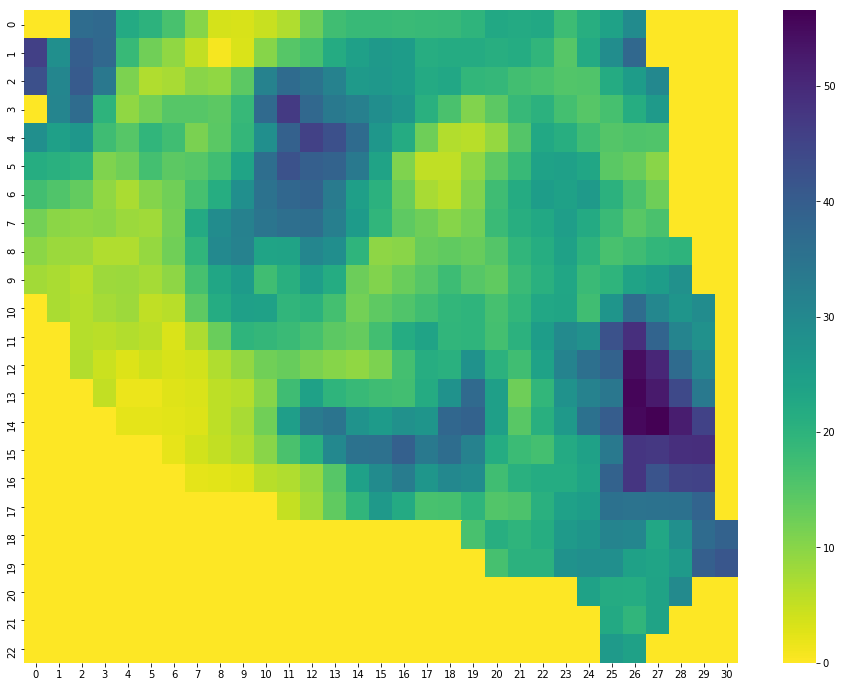

In [104]:
grid = np.zeros(shape = (submission_df['lat_adj'].max()+1, submission_df['lon_adj'].max()+1))
for region in submission_df['region_id_adj'].unique():
    i, j = region
    grid[i,j] = submission_df[(submission_df['lat_adj'] == i) & (submission_df['lon_adj'] == j)]['prec34']

plt.subplots(figsize=(16,12))
sns.heatmap(grid, cmap='viridis_r')

**prec56**

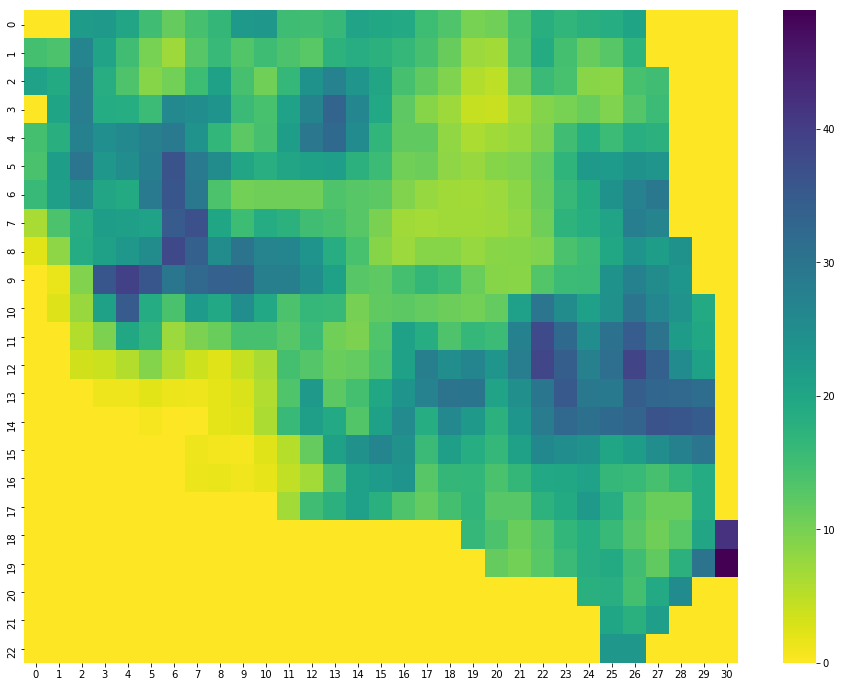

In [105]:
grid = np.zeros(shape = (submission_df['lat_adj'].max()+1, submission_df['lon_adj'].max()+1))
for region in submission_df['region_id_adj'].unique():
    i, j = region
    grid[i,j] = submission_df[(submission_df['lat_adj'] == i) & (submission_df['lon_adj'] == j)]['prec56']

plt.subplots(figsize=(16,12))
sns.heatmap(grid, cmap='viridis_r')